[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mcosarinsky/Freqtrade/blob/main/modelos/XGBoost.ipynb)

## Load data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, auc, precision_score, average_precision_score, precision_recall_curve 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid, cross_validate
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from joblib import Parallel, delayed
from tqdm import tqdm
from joblib import load, dump
from xgboost import XGBClassifier
from expected_cost import ec, utils
from helper_functions import get_results_df
import time

sns.set_theme()
datos_url = './datos/crypto_1h_filtered.csv'
df = pd.read_csv(datos_url, parse_dates=['startDate', 'endDate'])
df.dropna(inplace=True)
df.sort_values(by='startDate', inplace=True)
df

,open_1,high_1,low_1,close_1,open_2,high_2,low_2,close_2,open_3,high_3,...,open_13,high_13,low_13,close_13,open_14,high_14,low_14,close_14,Partitor,label
0,-0.004888,-0.001396,-0.004213,-0.005610,-0.004912,-0.004892,-0.003526,-0.002821,-0.002116,-0.002809,...,0.000000,0.005722,0.000000,0.007174,0.007897,0.004979,0.007194,0.004986,TRAIN,0.0
1,0.007267,-0.000985,0.004557,-0.002403,-0.002398,0.009776,0.000228,0.009381,0.009376,-0.000016,...,-0.002536,-0.003530,-0.003465,-0.004197,-0.004192,0.000660,0.001296,0.002564,TRAIN,0.0
2,0.013524,0.009648,0.012994,0.010468,0.010466,0.014205,0.006545,0.015281,0.015018,0.005093,...,-0.001925,-0.004112,0.003650,-0.010738,-0.010193,0.006606,0.001958,0.011968,TRAIN,0.0
3,-0.010910,0.004099,-0.002340,0.010642,0.010382,-0.001021,0.004560,-0.009375,-0.009247,-0.002554,...,-0.009928,-0.018132,-0.025760,-0.015307,-0.015437,0.008706,0.007322,0.008309,TRAIN,0.0
4,-0.002554,-0.006061,-0.012386,-0.004567,-0.004603,-0.004915,-0.003781,-0.002945,-0.002945,0.008144,...,0.001202,0.004344,-0.001111,-0.001893,-0.001893,-0.007740,-0.009044,-0.008636,TRAIN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34578,0.012322,0.000586,0.007368,-0.005988,-0.006086,0.003220,0.000791,0.011159,0.011160,0.020233,...,0.009074,0.004905,0.008798,0.008316,0.008219,-0.000670,0.003101,-0.003357,TEST,1.0
34579,-0.006086,0.003220,0.000791,0.011159,0.011160,0.020233,0.010074,0.015529,0.015628,-0.003337,...,0.008219,-0.000670,0.003101,-0.003357,-0.003453,0.000575,-0.000193,-0.001443,TEST,1.0
34580,0.011160,0.020233,0.010074,0.015529,0.015628,-0.003337,0.010854,0.001154,0.001250,0.006218,...,-0.003453,0.000575,-0.000193,-0.001443,-0.001347,0.004212,0.000000,0.009926,TEST,1.0
34581,0.015628,-0.003337,0.010854,0.001154,0.001250,0.006218,0.004546,0.003362,0.003170,-0.003898,...,-0.001347,0.004212,0.000000,0.009926,0.009926,0.001620,0.000000,-0.008779,TEST,1.0


In [2]:
exclude_cols = ['startDate', 'endDate', 'profits', 'coin']
df_filt = df.filter(regex='^(?!volume)') # elimino columnas de volume

df_dev = df_filt[(df_filt.startDate < "2023-06-01")]
df_test = df_filt[(df_filt.startDate >= "2023-06-01")]

X_dev, y_dev = df_dev.drop(exclude_cols,axis=1), df_dev['profits']
X_test, y_test = df_test.drop(exclude_cols,axis=1), df_test['profits']

print(X_dev.shape)
print(X_test.shape)
print(f"{len(df_dev)/(len(df_dev) + len(df_test)):.2f}")

(148022, 56)
(38227, 56)
0.79


In [3]:
from collections import Counter


def balancear_dataset(df, n_drop=0):
    class_0 = df[df['profits'] < 0]
    rows_to_delete = class_0.sample(n=n_drop, random_state=42)
    
    df_balanced = df.drop(rows_to_delete.index)
    
    return df_balanced

df_balanced = balancear_dataset(df_dev, n_drop=30000)

In [4]:
print('Distribucion original:',(df_dev.profits > 0).sum(), (df_dev.profits <= 0).sum())
print('Distribucion balanceando:', (df_balanced.profits > 0).sum(), (df_balanced.profits <= 0).sum())

X_dev, y_dev = df_balanced.drop(exclude_cols,axis=1), df_balanced['profits']
X_test, y_test = df_test.drop(exclude_cols,axis=1), df_test['profits']

Distribucion original: 57478 90544
Distribucion balanceando: 57478 60544


## Training

In [5]:
tscv = TimeSeriesSplit(n_splits=5, gap=10)


search_space = {'eta': (0.01,0.2),
                'n_estimators':(50,350),
                'max_depth':(2,5),
                'gamma':(0,5),
                'subsample':(0.5,0.9),
                'alpha':(50,100),
                'lambda':(25,100) 
               }

search_space_pr = {'eta': (0.01,0.2),
                  'n_estimators':(50,350),
                  'max_depth':(2,5),
                  'gamma':(0,5),
                  'subsample':(0.5,0.9),
                  'alpha':(40,75),
                  'lambda':(25,50)
                  }

xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc')

opt_roc = BayesSearchCV(xgb, search_space, n_iter=30, return_train_score=True, scoring='roc_auc',
                        cv=tscv, random_state=42, n_jobs=1, n_points=2, verbose=0)

opt_pr = BayesSearchCV(xgb, search_space_pr, n_iter=30, return_train_score=True, scoring='average_precision',
                       cv=tscv, random_state=42, n_jobs=1, n_points=2, verbose=0)

In [6]:
threshold = 0
y_dev_binary, y_test_binary = y_dev > threshold, y_test > threshold

start_time = time.time()

In [26]:
threshold = 0
y_dev_binary, y_test_binary = y_dev > threshold, y_test > threshold

start_time = time.time()

# Optimizando ROC-AUC
opt_roc.fit(X_dev, y_dev_binary)
res_roc = get_results_df(opt_roc)

# Optimizando PR-AUC
opt_pr.fit(X_dev, y_dev_binary)
res_pr = get_results_df(opt_pr)

print(f"Total time: {(time.time()-start_time)/60:.2f}m")
res_roc[:10]

Total time: 6.42m


,mean_test_score,mean_train_score,params,alpha,eta,gamma,lambda,max_depth,n_estimators,subsample
rank_test_score,,,,,,,,,,
1,0.522012,0.550059,"{'alpha': 90, 'eta': 0.09322554542377544, 'gam...",90,0.093226,3,79,5,265,0.669671
2,0.521405,0.549998,"{'alpha': 83, 'eta': 0.07708593065031456, 'gam...",83,0.077086,3,63,5,127,0.605936
3,0.521293,0.547839,"{'alpha': 68, 'eta': 0.13078852935704235, 'gam...",68,0.130789,5,72,5,280,0.65541
4,0.521289,0.551826,"{'alpha': 66, 'eta': 0.19982740920167333, 'gam...",66,0.199827,4,100,4,286,0.559802
5,0.521271,0.542155,"{'alpha': 87, 'eta': 0.06784802909693617, 'gam...",87,0.067848,3,66,2,103,0.752838
6,0.520877,0.546803,"{'alpha': 91, 'eta': 0.04265559666534654, 'gam...",91,0.042656,3,85,4,79,0.80232
7,0.520815,0.545084,"{'alpha': 83, 'eta': 0.029718942921899354, 'ga...",83,0.029719,4,25,3,227,0.734532
8,0.520717,0.543129,"{'alpha': 81, 'eta': 0.01288228888365021, 'gam...",81,0.012882,5,100,4,350,0.601142
9,0.520616,0.541726,"{'alpha': 88, 'eta': 0.11589468037642225, 'gam...",88,0.115895,5,78,3,109,0.70382


In [27]:
res_pr[:10]

,mean_test_score,mean_train_score,params,alpha,eta,gamma,lambda,max_depth,n_estimators,subsample
rank_test_score,,,,,,,,,,
1,0.493967,0.567059,"{'alpha': 70, 'eta': 0.018278236668501244, 'ga...",70,0.018278,5,37,5,271,0.867924
2,0.493645,0.561663,"{'alpha': 75, 'eta': 0.044534190005787025, 'ga...",75,0.044534,5,50,2,350,0.817877
3,0.493506,0.566859,"{'alpha': 75, 'eta': 0.05484680980179704, 'gam...",75,0.054847,5,50,5,350,0.9
4,0.493135,0.580242,"{'alpha': 62, 'eta': 0.11521284136684234, 'gam...",62,0.115213,0,50,2,74,0.814283
5,0.493027,0.560264,"{'alpha': 75, 'eta': 0.01, 'gamma': 5, 'lambda...",75,0.01,5,28,2,350,0.9
6,0.492968,0.562409,"{'alpha': 73, 'eta': 0.18560179166041843, 'gam...",73,0.185602,5,47,2,332,0.876761
7,0.492827,0.562867,"{'alpha': 57, 'eta': 0.12721815050105223, 'gam...",57,0.127218,5,30,2,50,0.9
8,0.492731,0.559777,"{'alpha': 75, 'eta': 0.1403408079132702, 'gamm...",75,0.140341,5,50,2,50,0.681465
9,0.492649,0.575185,"{'alpha': 44, 'eta': 0.041296953034454874, 'ga...",44,0.041297,5,50,5,335,0.520196


from catboost import CatBoostClassifier

cb_space = {'eta': (0.01,0.2,'log-uniform'),
            'max_depth':(2,5),
            'n_estimators':(50,250),
            'subsample':(0.5,0.9),
            'reg_lambda':(5000,8000,'uniform'),
            'min_data_in_leaf': (100, 200),
            'random_strength': (1000, 2000),
           }

cb = CatBoostClassifier(random_seed=42, verbose=False, thread_count=4)
opt_cb = BayesSearchCV(cb, cb_space, n_iter=35, return_train_score=True, scoring='average_precision',
                       cv=tscv, random_state=42, n_jobs=-1, n_points=2, verbose=0)
opt_cb.fit(X_dev, y_dev_binary.astype(int))
res_cb = get_results_df(opt_cb)
res_cb[:10]

## Evaluation

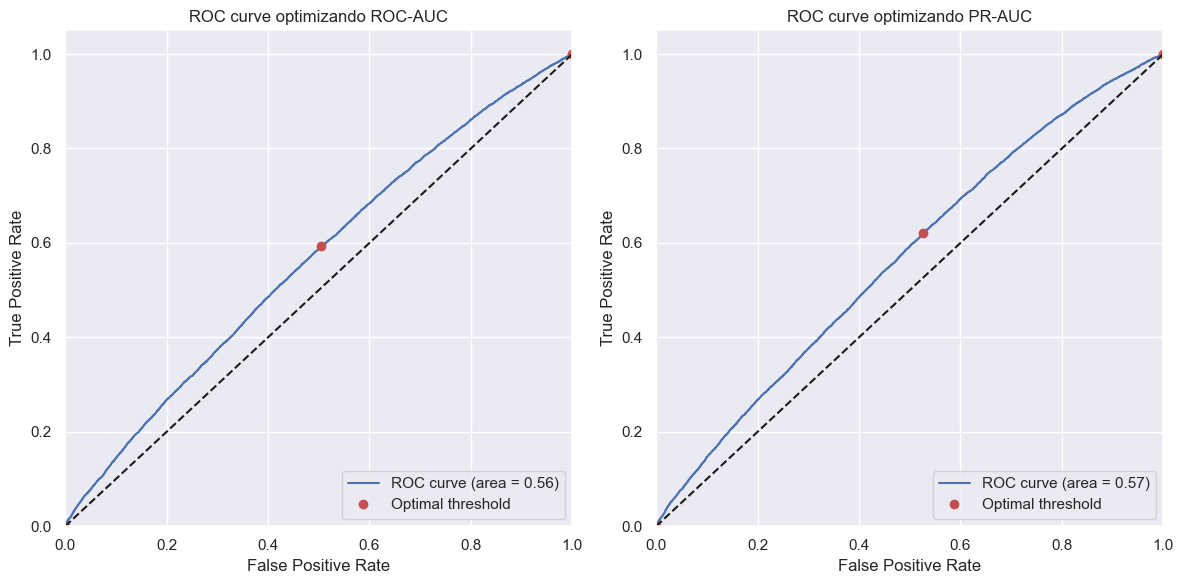

In [28]:
clf_roc = XGBClassifier(**res_roc.iloc[0,:].params, objective='binary:logistic', eval_metric='auc')
clf_roc.fit(X_dev, y_dev_binary)
y_probas_roc = clf_roc.predict_proba(X_test)[:,1]

clf_pr = XGBClassifier(**res_pr.iloc[0,:].params, objective='binary:logistic', eval_metric='auc')
clf_pr.fit(X_dev, y_dev_binary)
y_probas_pr = clf_pr.predict_proba(X_test)[:,1]

fpr_roc, tpr_roc, thresholds_roc = roc_curve(y_test_binary, y_probas_roc)
optimal_threshold_roc = thresholds_roc[np.argmax(tpr_roc-fpr_roc)]
fpr_optimal_roc, tpr_optimal_roc, _ = roc_curve(y_test_binary, y_probas_roc > optimal_threshold_roc)
roc_auc_roc = roc_auc_score(y_test_binary, y_probas_roc)

fpr_pr, tpr_pr, thresholds_pr = roc_curve(y_test_binary, y_probas_pr)
optimal_threshold_pr = thresholds_pr[np.argmax(tpr_pr - fpr_pr)]
fpr_optimal_pr, tpr_optimal_pr, _ = roc_curve(y_test_binary, y_probas_pr > optimal_threshold_pr)
roc_auc_pr = roc_auc_score(y_test_binary, y_probas_pr)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.set_theme()

# Plot ROC curve for clf_roc
axs[0].plot(fpr_roc, tpr_roc, label='ROC curve (area = %0.2f)' % roc_auc_roc)
axs[0].plot(fpr_optimal_roc, tpr_optimal_roc, 'ro', label='Optimal threshold')  
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC curve optimizando ROC-AUC')
axs[0].legend(loc="lower right")

# Plot ROC curve for clf_pr
axs[1].plot(fpr_pr, tpr_pr, label='ROC curve (area = %0.2f)' % roc_auc_pr)
axs[1].plot(fpr_optimal_pr, tpr_optimal_pr, 'ro', label='Optimal threshold')  
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC curve optimizando PR-AUC')
axs[1].legend(loc="lower right")

# Display the figure
plt.tight_layout()
plt.show()

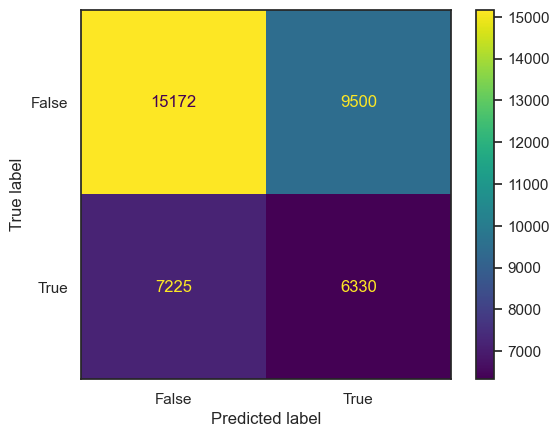

In [35]:
#dump(clf_pr, './clasificadores/indicadores.pkl')

y_pred = y_probas_pr > 0.46

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_predictions(y_test_binary, y_pred)

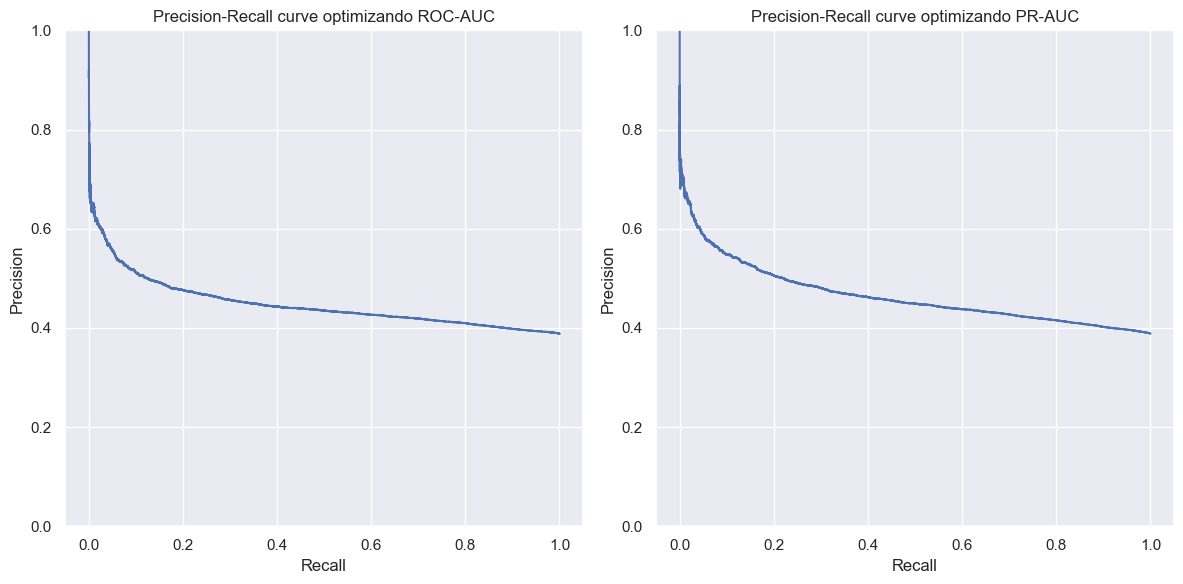

In [18]:
precision_roc, recall_roc, thresholds_roc = precision_recall_curve(y_test_binary, y_probas_roc)
#beta = 0.22
#fbeta_scores = [fbeta_score(y_test_binary, y_probas > t, beta=beta) for t in thresholds]
#optimal_idx = np.argmax(fbeta_scores)
#optimal_threshold_pr = thresholds[optimal_idx]ñ
#optimal_precision = precision[optimal_idx]
#optimal_recall = recall[optimal_idx]

sns.set_theme()
# Calculate precision and recall for clf_pr
precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_test_binary, y_probas_pr)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Precision-Recall curve for clf_roc
axs[0].plot(recall_roc, precision_roc)
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall curve optimizando ROC-AUC')
axs[0].set_ylim(0.0,1)

# Plot Precision-Recall curve for clf_pr
axs[1].plot(recall_pr, precision_pr)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall curve optimizando PR-AUC')
axs[1].set_ylim(0.0,1)

# Display the figure
plt.tight_layout()
plt.show()


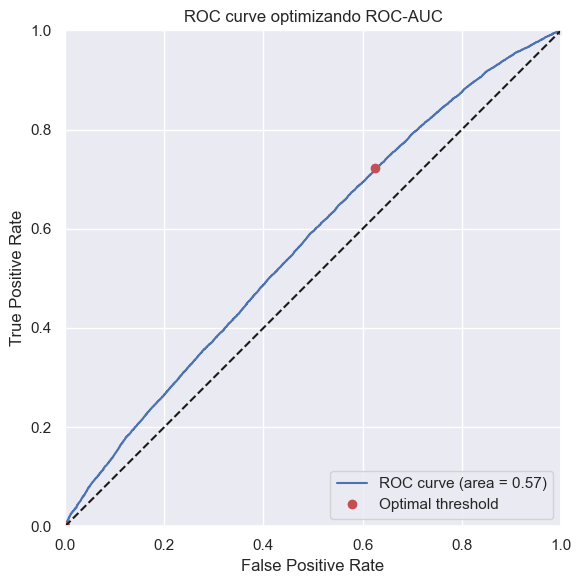

In [6]:
# Cargo clasificador para 1h
threshold = 0
y_dev_binary, y_test_binary = y_dev > threshold, y_test > threshold

clf_roc_1h = load('./clasificadores/xgb_roc_1h.pkl')
y_probas_roc = clf_roc_1h.predict_proba(X_test)[:,1]

fpr_roc, tpr_roc, thresholds_roc = roc_curve(y_test_binary, y_probas_roc)
optimal_threshold_roc = thresholds_roc[np.argmax(tpr_roc - fpr_roc)]
fpr_optimal_roc, tpr_optimal_roc, _ = roc_curve(y_test_binary, y_probas_roc > optimal_threshold_roc)
roc_auc_roc = roc_auc_score(y_test_binary, y_probas_roc)

fig, ax = plt.subplots(figsize=(6, 6))  # Adjust to a square figsize
sns.set_theme()

# Plot ROC curve for clf_roc
ax.plot(fpr_roc, tpr_roc, label='ROC curve (area = %0.2f)' % roc_auc_roc)
ax.plot(fpr_optimal_roc, tpr_optimal_roc, 'ro', label='Optimal threshold')
ax.plot([0, 1], [0, 1], 'k--')

# Make both axes symmetrical
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_aspect('equal', adjustable='box')  # Ensure the plot is square

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve optimizando ROC-AUC')
ax.legend(loc="lower right")

plt.tight_layout()  # Ensure everything is centered and fits well
plt.show()


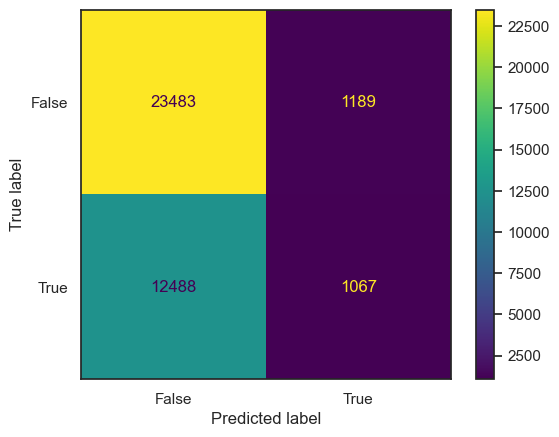

In [9]:
y_pred = y_probas_roc > 0.41

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_predictions(y_test_binary, y_pred)

In [53]:
#dump(clf_pr, './clasificadores/indicadores.pkl')

['./clasificadores/indicadores.pkl']

## Saving

0.48201936376210236

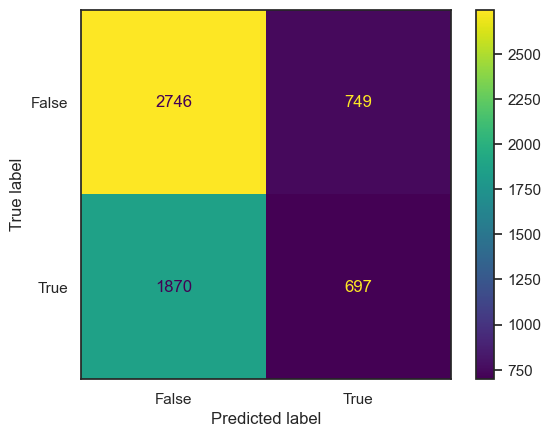

In [12]:
from joblib import dump, load

threshold = 0
y_dev_binary, y_test_binary = y_dev > threshold, y_test > threshold
clf, thr = load('clf_2.joblib')
y_pred = clf.predict_proba(X_test)[:,1] > thr

sns.set_style("white")

disp = ConfusionMatrixDisplay.from_predictions(y_test_binary, y_pred)
697/(697+749)

## Datos BTC

In [2]:
from importlib import reload
import helper_functions
reload(helper_functions)

df = pd.read_csv('./datos/Data_IntercambioBTC_F2_nuevo.csv')
df.dropna(inplace=True)
df['startDate'] = pd.to_datetime(df['startDate'])
df['endDate'] = pd.to_datetime(df['endDate'])
df.sort_values(by='startDate', inplace=True)

In [6]:
exclude_cols = ['startDate', 'endDate', 'Partitor', 'profits', 'Crypto']

#df_train = df[df.Partitor=='TRAIN']
#df_test = df[df.Partitor=='TEST']
#df_validate = df[df.Partitor=='VALIDATE']

# Remove volume
#df_train = df_train[[col for col in df_train.columns if not col.startswith('volume')]]
#df_test = df_test[[col for col in df_test.columns if not col.startswith('volume')]]
#df_validate = df_validate[[col for col in df_validate.columns if not col.startswith('volume')]]

# Splits
#X_train, y_train = df_train.drop(exclude_cols,axis=1), df_train['profits']
#X_test, y_test = df_validate.drop(exclude_cols,axis=1), df_validate['profits']
#X_dev, y_dev = pd.concat([X_train, X_test]), pd.concat([y_train, y_test])
#X_eval, y_eval = df_test.drop(exclude_cols,axis=1), df_test['profits']

df_dev = df[df.startDate <= pd.to_datetime("2023-01-01")]
df_test = df[df.startDate > pd.to_datetime("2023-01-01")]
df_dev = df_dev[[col for col in df_dev.columns if not col.startswith('volume')]]
df_test = df_test[[col for col in df_test.columns if not col.startswith('volume')]]

X_dev, y_dev = df_dev.drop(exclude_cols,axis=1), df_dev['profits']
X_eval, y_eval = df_test.drop(exclude_cols,axis=1), df_test['profits']

y_dev_binary, y_eval_binary = y_dev > 0, y_eval > 0

print(X_dev.shape, y_dev.shape)
print(X_eval.shape, y_eval.shape)
print(f"{len(df_test)/len(df):.3f}")

(9003, 56) (9003,)
(2499, 56) (2499,)
0.217


## Training

In [14]:
tscv = TimeSeriesSplit(n_splits=5)

def make_pipeline(model):
    steps = [('preprocessor', StandardScaler()), ('classifier', model)]
    return Pipeline(steps)

costs = ec.CostMatrix([[0, 1.25], [1, -0.3]])
def expected_cost_scorer(estimator, X, y):
    targets = y
    scores = estimator.predict_proba(X)
    cost, _ = ec.average_cost_for_bayes_decisions(y, scores, costs=costs, score_type='posteriors')
    return -cost

search_space = {'eta': (0.01,0.2,'log-uniform'),
                'n_estimators':(50,350),
                'max_depth':(2,5),
                #'min_child_weight':(50,100),
                'gamma':(1,5,'uniform'),
                'subsample':(0.5,0.9),
                'alpha':(25,50,'uniform'),
                'lambda':(75,200,'uniform')
               }


xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc')
weights = np.abs(y_dev)

opt = BayesSearchCV(xgb, search_space, n_iter=35, return_train_score=True, scoring='average_precision', 
                    fit_params={'sample_weight': weights}, cv=tscv, random_state=42, n_jobs=-1, n_points=2, verbose=0)

In [15]:
start_time = time.time()
opt.fit(X_dev, y_dev_binary)

res_xgb = get_results_df(opt)
print(f"Total time: {(time.time()-start_time)/60:.2f}m")
res_xgb[:10]

Total time: 4.18m


,mean_test_score,mean_train_score,params,alpha,eta,gamma,lambda,max_depth,n_estimators,subsample
rank_test_score,,,,,,,,,,
1,0.420945,0.551032,"{'alpha': 26, 'eta': 0.010720768963722628, 'ga...",26,0.010721,1,151,5,312,0.675001
2,0.420429,0.556437,"{'alpha': 25, 'eta': 0.03665795386766643, 'gam...",25,0.036658,1,86,5,50,0.724989
3,0.419904,0.553737,"{'alpha': 25, 'eta': 0.06355850156975071, 'gam...",25,0.063559,1,119,5,152,0.517148
4,0.418716,0.536556,"{'alpha': 25, 'eta': 0.01, 'gamma': 1, 'lambda...",25,0.01,1,125,5,350,0.5
5,0.418665,0.539152,"{'alpha': 26, 'eta': 0.010557198713749267, 'ga...",26,0.010557,1,117,5,90,0.674692
6,0.417092,0.515572,"{'alpha': 25, 'eta': 0.01, 'gamma': 1, 'lambda...",25,0.01,1,80,5,50,0.5
7,0.416749,0.529000,"{'alpha': 27, 'eta': 0.01, 'gamma': 1, 'lambda...",27,0.01,1,75,5,50,0.653208
8,0.413977,0.618943,"{'alpha': 25, 'eta': 0.2, 'gamma': 1, 'lambda'...",25,0.2,1,75,5,204,0.692334
9,0.413414,0.537755,"{'alpha': 27, 'eta': 0.037863356402673076, 'ga...",27,0.037863,1,162,3,350,0.747278


In [16]:
clf = XGBClassifier(**res_xgb.iloc[0,:].params, objective='binary:logistic', eval_metric='auc')
clf.fit(X_dev, y_dev_binary)
y_probas = clf.predict_proba(X_eval)
cost, decisions = ec.average_cost_for_bayes_decisions(y_eval_binary, y_probas, costs=costs, score_type='posteriors')

#sns.set_style("white")
#ConfusionMatrixDisplay.from_predictions(y_eval_binary, decisions)

average_precision_score(y_eval_binary, y_probas[:,1])

0.4431981332924787

In [60]:
from catboost import CatBoostClassifier

cb_space = {'eta': (0.01,0.2,'log-uniform'),
            'max_depth':(2,5),
            'n_estimators':(50,250),
            'subsample':(0.5,0.9),
            'reg_lambda':(5000,8000,'uniform'),
            'min_data_in_leaf': (100, 200),
            'random_strength': (1000, 2000),
           }

cb = CatBoostClassifier(random_seed=42, verbose=False, thread_count=4)
opt_cb = BayesSearchCV(cb, cb_space, n_iter=40, return_train_score=True, scoring=expected_cost_scorer,
                       cv=tscv, random_state=42, n_jobs=-1, n_points=2, verbose=0)
opt_cb.fit(X_dev, y_dev_binary.astype(int))
res_cb = get_results_df(opt_cb)
res_cb[:10]

,mean_test_score,mean_train_score,params,eta,max_depth,min_data_in_leaf,n_estimators,random_strength,reg_lambda,subsample
rank_test_score,,,,,,,,,,
1,-0.456587,-0.331536,"{'eta': 0.2, 'max_depth': 5, 'min_data_in_leaf...",0.2,5,100,205,2000,8000,0.5
2,-0.457287,-0.369469,"{'eta': 0.07957455832806426, 'max_depth': 5, '...",0.079575,5,161,250,2000,5847,0.791094
3,-0.457580,-0.298999,"{'eta': 0.2, 'max_depth': 5, 'min_data_in_leaf...",0.2,5,185,231,1525,5039,0.692412
4,-0.457607,-0.326039,"{'eta': 0.14105059432354658, 'max_depth': 5, '...",0.141051,5,100,250,2000,5995,0.688754
5,-0.457780,-0.373313,"{'eta': 0.13383953555990172, 'max_depth': 5, '...",0.13384,5,200,163,1260,7082,0.502279
6,-0.459007,-0.408982,"{'eta': 0.13706492314133217, 'max_depth': 2, '...",0.137065,2,200,135,2000,7322,0.5
7,-0.459280,-0.375368,"{'eta': 0.09501504679762099, 'max_depth': 4, '...",0.095015,4,197,191,1381,5594,0.70382
8,-0.459420,-0.337428,"{'eta': 0.12287608582119026, 'max_depth': 5, '...",0.122876,5,130,240,1864,5187,0.555323
9,-0.459573,-0.394622,"{'eta': 0.06532715127793824, 'max_depth': 5, '...",0.065327,5,167,250,1252,7329,0.730102


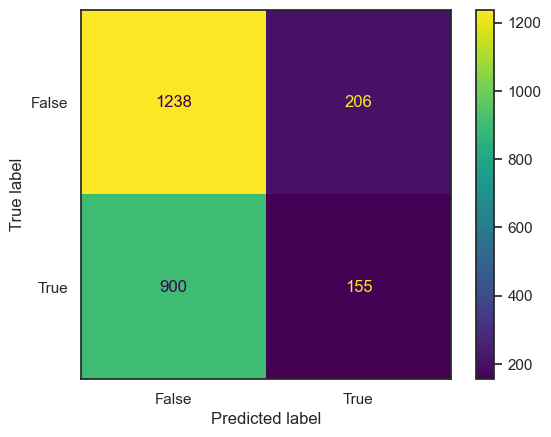

In [61]:
clf = CatBoostClassifier(**res_cb.iloc[0,:].params, random_seed=42, verbose=False, thread_count=4)
clf.fit(X_dev, y_dev_binary)
y_probas = clf.predict_proba(X_eval)
cost, decisions = ec.average_cost_for_bayes_decisions(y_eval_binary, y_probas, costs=costs, score_type='posteriors')

ConfusionMatrixDisplay.from_predictions(y_eval_binary, decisions)

In [108]:
from sklearn.ensemble import RandomForestClassifier

rf_space = {'max_depth':(2,4),
            'n_estimators':(50,350),
            'max_features':['sqrt','log2'],
            'min_samples_split':(200,400),
            'min_samples_leaf':(300,600),
           # 'ccp_alpha':(0.0,0.005)
           }

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
opt_rf = BayesSearchCV(rf, rf_space, n_iter=30, return_train_score=True, scoring='roc_auc',
                       cv=tscv, random_state=42, n_jobs=-1, n_points=2, verbose=0)

opt_rf.fit(X_dev, y_dev_binary)
res_rf = get_results_df(opt_rf)
res_rf[:10]

,mean_test_score,mean_train_score,params,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
rank_test_score,,,,,,,,
1,0.526701,0.604763,"{'max_depth': 2, 'max_features': 'sqrt', 'min_...",2,sqrt,405,200,253
2,0.525995,0.607357,"{'max_depth': 2, 'max_features': 'sqrt', 'min_...",2,sqrt,350,200,350
3,0.525963,0.604752,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",3,sqrt,445,202,192
4,0.525510,0.611225,"{'max_depth': 2, 'max_features': 'log2', 'min_...",2,log2,303,246,188
5,0.525382,0.611656,"{'max_depth': 2, 'max_features': 'sqrt', 'min_...",2,sqrt,302,369,332
6,0.525189,0.612104,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",3,sqrt,414,204,343
7,0.525023,0.608465,"{'max_depth': 2, 'max_features': 'log2', 'min_...",2,log2,339,400,350
8,0.524962,0.604396,"{'max_depth': 2, 'max_features': 'log2', 'min_...",2,log2,406,327,336
9,0.524919,0.618410,"{'max_depth': 4, 'max_features': 'sqrt', 'min_...",4,sqrt,391,390,309


In [109]:
clf = RandomForestClassifier(**res_rf.iloc[0,:].params, random_state=42, n_jobs=-1)
clf.fit(X_dev, y_dev_binary)
y_probas = clf.predict_proba(X_eval)[:,1]
roc_auc_score(y_eval_binary, y_probas)

0.5269022987751244

## Evaluacion

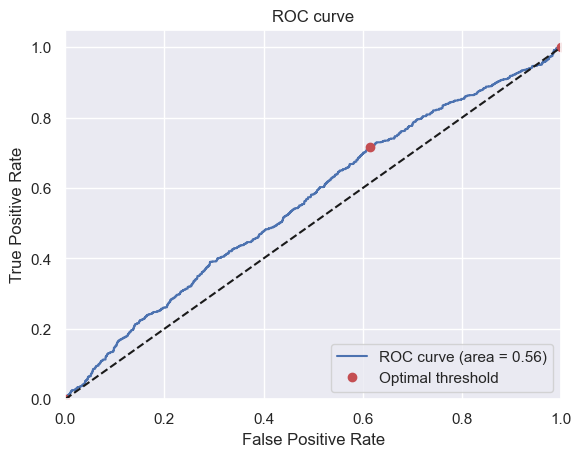

In [83]:
#clf = XGBClassifier(**res.iloc[0,:].params, objective='binary:logistic', eval_metric='auc')
clf = CatBoostClassifier(**res_cb.iloc[0,:].params, random_seed=42, verbose=False, thread_count=4)
clf.fit(X_dev, y_dev_binary)
y_probas = clf.predict_proba(X_eval)[:,1]

fpr, tpr, thresholds = roc_curve(y_eval_binary, y_probas)
optimal_threshold = thresholds[np.argmax(tpr-fpr)]
fpr_optimal, tpr_optimal, _ = roc_curve(y_eval_binary, y_probas > optimal_threshold)
roc_auc = roc_auc_score(y_eval_binary, y_probas)

sns.set_theme()
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_optimal, tpr_optimal, 'ro', label='Optimal threshold')  
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

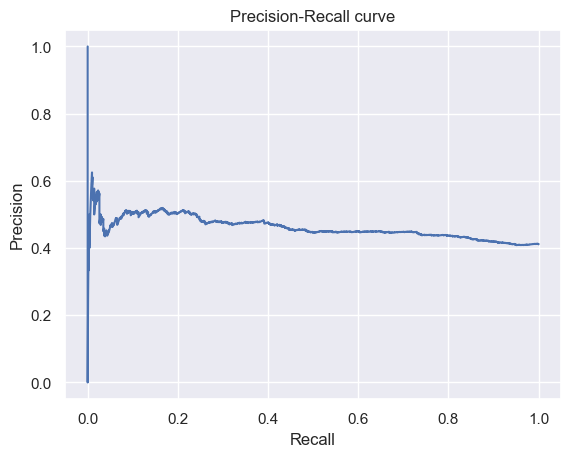

In [84]:
precision, recall, thresholds = precision_recall_curve(y_eval_binary, y_probas)

sns.set_theme()
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


In [135]:
optimal_threshold

0.43096112816122406

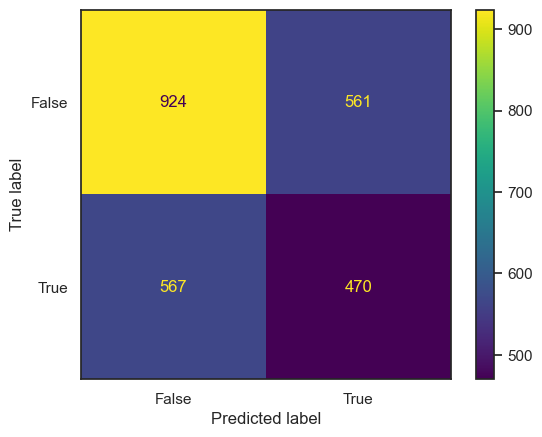

In [137]:
thr = 0.44
sns.set_theme(style="white")
disp = ConfusionMatrixDisplay.from_predictions(y_eval_binary, y_probas > thr)

## Save model

In [129]:
dump(clf, './clasificadores/catboost.pkl')

['./clasificadores/catboost.pkl']